In [ ]:
# 2025/12/14
# zhangzhong
# https://docs.langchain.com/oss/python/langgraph/persistence

In [ ]:
## Persistence
# LangGraph has a built-in persistence layer, implemented through checkpointers. 
# When you compile a graph with a checkpointer, the checkpointer saves a checkpoint of the graph state at every super-step.
# super-step是什么意思？切换node的时候？ 
# - Each sequential node is a separate super-step
# - parallel nodes share the same super-step
# Those checkpoints are saved to a thread, which can be accessed after graph execution.
# Because threads allow access to graph’s state after execution, several powerful capabilities including human-in-the-loop, memory, time travel, and fault-tolerance are all possible

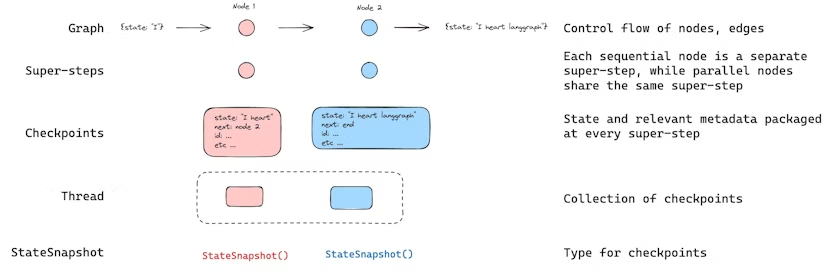

In [ ]:
## Threads
# A thread is a unique ID or thread identifier assigned to each checkpoint saved by a checkpointer.
# it contains the accumulated state of a sequence of runs
# When a run is executed, the state of the underlying graph of the assistant will be persisted to the thread.
# 可以想象成每次checkpoint就是一个平行世界，可以从任意checkpoint开启一段新的对话

# When invoking a graph with a checkpointer, you must specify a thread_id as part of the configurable portion of the config:
# {"configurable": {"thread_id": "1"}}
# The checkpointer uses thread_id as the primary key for storing and retrieving checkpoints.

In [ ]:
## Checkpoints
# The state of a thread at a particular point in time is called a checkpoint.
# Checkpoint is a [snapshot of the graph state] saved at each super-step and is represented by [StateSnapshot]
## StateSnapshot
# - config: Config associated with this checkpoint.
# - metadata: Metadata associated with this checkpoint.
# - values: Values of the state channels at this point in time.
# - next A tuple of the node names to execute next in the graph.
# - tasks: A tuple of PregelTask objects that contain information about next tasks to be executed. If the step was previously attempted, it will include error information. If a graph was interrupted dynamically from within a node, tasks will contain additional data associated with interrupts.

## checkpoint的目的就是为了resume，所以保存的这些信息的目的就是为了还原当时的状态和接下来要执行的动作的状态

In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    foo: str
    bar: Annotated[list[str], add]

def node_a(state: State):
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

config: RunnableConfig = {"configurable": {"thread_id": "1"}}
graph.invoke({"foo": "", "bar":[]}, config)

{'foo': 'b', 'bar': ['a', 'b']}

In [ ]:
## How to retrieve the snapshot?

# After we run the graph, we expect to see exactly 4 checkpoints:
# - Empty checkpoint with START as the next node to be executed
# - Checkpoint with the user input {'foo': '', 'bar': []} and node_a as the next node to be executed
# - Checkpoint with the outputs of node_a {'foo': 'a', 'bar': ['a']} and node_b as the next node to be executed
# - Checkpoint with the outputs of node_b {'foo': 'b', 'bar': ['a', 'b']} and no next nodes to be executed

# When interacting with the saved graph state, you must specify a thread identifier. 


In [ ]:
# 所以thread id实际上就是一系列的对话，有点像一次session
# # You can view the latest state of the graph by calling graph.get_state(config)
# get the latest state snapshot
# This will return a StateSnapshot object that corresponds to the latest checkpoint associated with the thread ID
config = {"configurable": {"thread_id": "1"}}
graph.get_state(config)

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d8a05-38f0-6c78-8002-395051e77c43'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}, 'thread_id': '1'}, created_at='2025-12-14T03:52:35.673608+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d8a05-38f0-632c-8001-96593791d77a'}}, tasks=(), interrupts=())

In [ ]:
StateSnapshot(
    # values: Values of the state channels at this point in time.
    values={'foo': 'b', 'bar': ['a', 'b']},
    # next: A tuple of the node names to execute next in the graph.
    next=(),
    # config: Config associated with this checkpoint.
    config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef663ba-28fe-6528-8002-5a559208592c'}},
    # metadata: Metadata associated with this checkpoint.
    metadata={'source': 'loop', 'writes': {'node_b': {'foo': 'b', 'bar': ['b']}}, 'step': 2},
    # 这里怎么和教程里面写的不一样捏
    created_at='2024-08-29T19:19:38.821749+00:00',
    parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef663ba-28f9-6ec4-8001-31981c2c39f8'}}, tasks=()
)

In [3]:
checkpoint_id = "1f0d8a05-38f0-6c78-8002-395051e77c43"
# get a state snapshot for a specific checkpoint_id
config = {"configurable": {"thread_id": "1", "checkpoint_id": checkpoint_id}}
graph.get_state(config)

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0d8a05-38f0-6c78-8002-395051e77c43'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}, 'thread_id': '1'}, created_at='2025-12-14T03:52:35.673608+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d8a05-38f0-632c-8001-96593791d77a'}}, tasks=(), interrupts=())

In [4]:
## Get state history
# You can get the full history of the graph execution for a given thread by calling graph.get_state_history(config). 
# ordered chronologically with the [most recent checkpoint] / StateSnapshot being the [first] in the list.
config = {"configurable": {"thread_id": "1"}}
list(graph.get_state_history(config))

[StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d8a05-38f0-6c78-8002-395051e77c43'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}, 'thread_id': '1'}, created_at='2025-12-14T03:52:35.673608+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d8a05-38f0-632c-8001-96593791d77a'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'foo': 'a', 'bar': ['a']}, next=('node_b',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d8a05-38f0-632c-8001-96593791d77a'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-12-14T03:52:35.673369+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d8a05-38ef-6526-8000-9db2aa8ff14f'}}, tasks=(PregelTask(id='e1954ea1-a8c1-5d85-ea72-0ed44e3efb29', name='node_b', path=('__pregel_pull

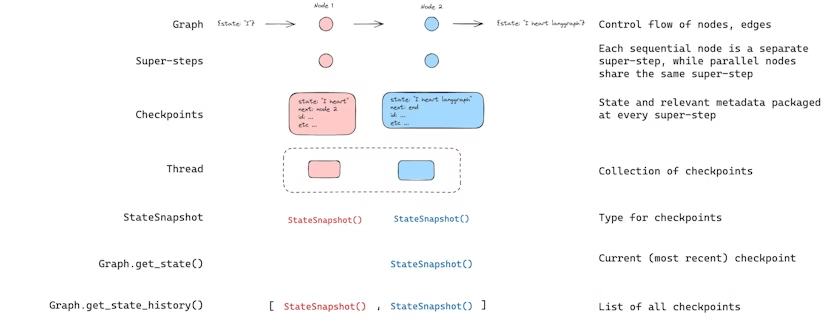

In [ ]:
# ## Replay
# # If we invoke a graph with a thread_id and a checkpoint_id, 
# # then we will re-play the previously executed steps before a checkpoint that corresponds to the checkpoint_id, 
# # and only execute the steps after the checkpoint. 应该就是Snapshot里面的next

# - thread_id is the ID of a thread.
# - checkpoint_id is an identifier that refers to a specific checkpoint within a thread.

config = {"configurable": {"thread_id": "1", "checkpoint_id": "0c62ca34-ac19-445d-bbb0-5b4984975b2a"}}
graph.invoke(None, config=config)

# 有点像git分支，replay就是reset到之前的一个点，然后重新commit代码
# All of the steps after checkpoint_id will be executed (i.e., a new fork), even if they have been executed previously

EmptyInputError: Received no input for __start__

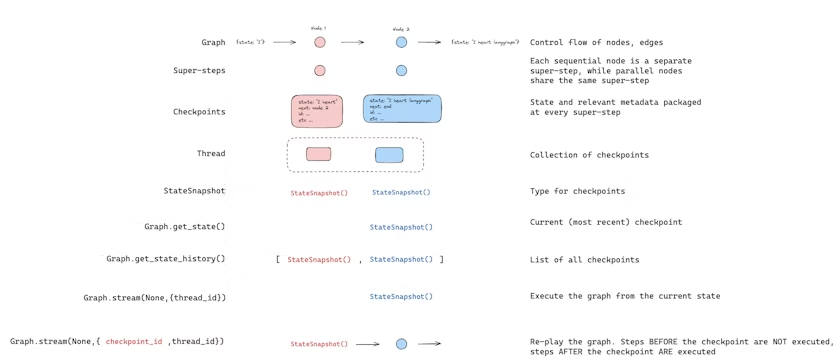

In [ ]:
## Update state
# 这样就可以改变时间线了！回到过去！改变世界
# In addition to re-playing the graph from specific checkpoints, we can also edit the graph state
# We do this using update_state. This method accepts three different arguments:
# - config of thread_id and checkpoint_id, only thread_id default to latest checkpoint
# - These are the values that will be used to update the state, [reduce] into the state just like other node output
#.  Note that this update is treated exactly as any update from a node is treated
#.  在这个文档里，state的每个filed被叫做channel，merge的操作叫做reduce

## as_node
# `as_node` tells LangGraph which node to pretend produced your manual update_state change, so the scheduler knows where to resume.
#!!!! 我懂了，update state本质上就是一次更新，state的更新都是来自node的，如果我们想要接下来执行的某个node，就把as_node设置成parent node就行了
# The final thing you can optionally specify when calling update_state is as_node
# - If you provided it, the update will be applied as if it came from node [as_node]
# - If `as_node` is not provided, it will be set to the last node that updated the state, if not ambiguous.
# 用来control which node executes next !!!

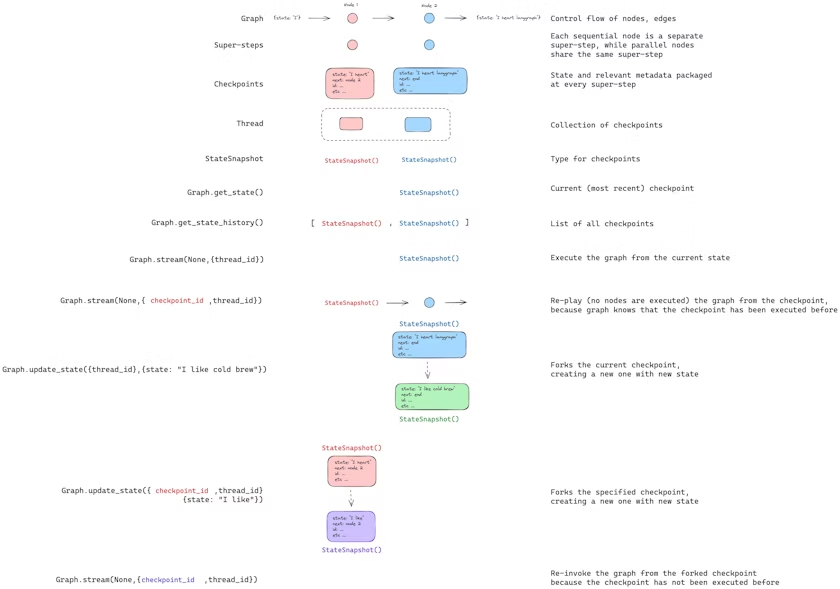

## Memory !!!

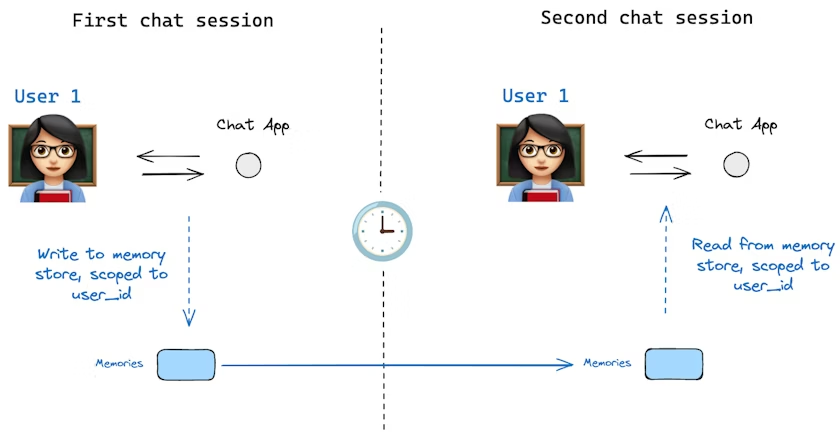

what if we want to retain some information across threads? Consider the case of a chatbot where we want to retain specific information about the user across all chat conversations (e.g., threads) with that user!


`Store` interface for share information across threads. 


In [ ]:
## Basic Usage

from langgraph.store.memory import InMemoryStore
import uuid

in_memory_store = InMemoryStore()

# what memory is
# In LangGraph’s memory/persistence, every stored state(dict) lives under a namespace key(tuple)
# A namespace is just a tuple of strings you choose, e.g. (<user_id>, "memories")

user_id = "1"
namespace_for_memory = (user_id, "memories")
# 如果这个namespcae是 userid threadid 就可以保存对话记录了，和每一次对话的结果，然后用户就可以在界面上选择某个对话，然后就可以resume！
# 就是这样！然后再选择 pgsql作为backend 完美！

# Store memory
# We use the store.put method to save memories to our namespace in the store
memory_id = str(uuid.uuid4())
memory = {"food_preference" : "I like pizza"} # this could be our graph state actually!
in_memory_store.put(namespace_for_memory, memory_id, memory)

In [7]:
## Search memory
# We can read out memories in our namespace using the store.search method, 
# which will return all memories for a given user as a [list]. 
# The most recent memory is the last in the list.
memories = in_memory_store.search(namespace_for_memory)
memories[-1].dict()

{'namespace': ['1', 'memories'],
 'key': '02fd88df-de2f-41d1-944d-adf9a7b597f5',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-12-14T04:27:17.112436+00:00',
 'updated_at': '2025-12-14T04:27:17.112451+00:00',
 'score': None}

In [ ]:
# SearchItem
{
    # namespace: A list of strings, the namespace of this memory type
    'namespace': ['1', 'memories'],
    # key: A unique key for this memory in this namespace, set when use store.put(key=memor_id)
    'key': '02fd88df-de2f-41d1-944d-adf9a7b597f5',
    # value: The value (itself a dictionary) of this memory
    'value': {'food_preference': 'I like pizza'},
    # created_at: Timestamp for when this memory was created
    'created_at': '2025-12-14T04:27:17.112436+00:00',
    # updated_at: Timestamp for when this memory was updated
    'updated_at': '2025-12-14T04:27:17.112451+00:00',
    # what?
    'score': None
}

In [8]:
## Embedding
from langchain_openai import  OpenAIEmbeddings
import os

api_key = os.environ["BIGMODEL_API_KEY"]


def get_embedding_model() -> OpenAIEmbeddings:
    """Return a configured OpenAI embeddings model for the Zhipu endpoint."""
    return OpenAIEmbeddings(
        model="embedding-3",
        api_key=api_key,
        base_url="https://open.bigmodel.cn/api/paas/v4/",
    )


In [9]:
## Semantic search on memory ? what?
# 也行！如果memory特别多的话，也可以做这个search，但是这样会拖慢速度，如果可以并行的提取memory就好了

from langchain.embeddings import init_embeddings

store = InMemoryStore(
    index={
        "embed": get_embedding_model(),  # Embedding provider
        "dims": 2048,                              # Embedding dimensions
        "fields": ["food_preference", "$"]              # Fields to embed
    }
)

In [10]:
# Find memories about food preferences
# (This can be done after putting memories into the store)
memories = store.search(
    namespace_for_memory,
    query="What does the user like to eat?",
    limit=3  # Return top 3 matches
)

In [11]:
print(memories)

[]


In [ ]:
# Store with specific fields to embed
store.put(
    namespace_for_memory,
    str(uuid.uuid4()),
    # value is just a dict associate with this memory
    {
        "food_preference": "I love Italian cuisine",
        "context": "Discussing dinner plans"
    },
    index=["food_preference"]  # Only embed "food_preferences" field
)

# Store without embedding (still retrievable, but not searchable)
store.put(
    namespace_for_memory,
    str(uuid.uuid4()),
    {"system_info": "Last updated: 2024-01-01"},
    index=False
)

In [ ]:
## Using in LangGraph

from langgraph.checkpoint.memory import InMemorySaver

# 是不是这个checkpointer也有其他的saver？比如pgsql saver？

# We need this because we want to enable threads (conversations)
checkpointer = InMemorySaver()

# ... Define the graph ...

# Compile the graph with the checkpointer and store
graph = graph.compile(checkpointer=checkpointer, store=in_memory_store)

In [ ]:
# the checkpointer saves state to threads
# the in_memory_store allows us to store arbitrary information for access across threads.
# 不对！对话历史就是在state里面，就是pgsql checkpointer就行！

# 

In [ ]:
# invoke a graph with thread_id and user_id
# Invoke the graph
user_id = "1"
# 这个config是任意的dict呗，设置可以放一个tag，用来分组
config = {"configurable": {"thread_id": "1", "user_id": user_id}}

# First let's just say hi to the AI
for update in graph.stream(
    {"messages": [{"role": "user", "content": "hi"}]}, config, stream_mode="updates"
):
    print(update)

In [ ]:

# We can access the in_memory_store and the user_id in any node by passing store: BaseStore and config: RunnableConfig as node arguments
# any node argument？你的意思我，我这样写node的function的参数，就可以拿到这些东西？.
def update_memory(state: MessagesState, config: RunnableConfig, *, store: BaseStore):

    # Get the user id from the config
    user_id = config["configurable"]["user_id"]

    # Namespace the memory
    namespace = (user_id, "memories")

    # ... Analyze conversation and create a new memory using LLM

    # Create a new memory ID
    memory_id = str(uuid.uuid4())

    # We create a new memory
    store.put(namespace, memory_id, {"memory": memory})

In [ ]:

# 还真是！
# Yes. LangGraph will “inject” what you declare in the node signature:
def call_model(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    # Get the user id from the config
    user_id = config["configurable"]["user_id"]

    # Namespace the memory
    namespace = (user_id, "memories")

    # Search based on the most recent message
    memories = store.search(
        namespace,
        query=state["messages"][-1].content,
        limit=3
    )
    info = "\n".join([d.value["memory"] for d in memories])

    # ... Use memories in the model call

In [ ]:
# If we create a new thread, we can still access the same memories so long as the user_id is the same.

# Invoke the graph
# user id 仍然是1，所以仍然可以找到我们自己的memory，哪怕是一个新的对话！
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# Let's say hi again
for update in graph.stream(
    {"messages": [{"role": "user", "content": "hi, tell me about my memories"}]}, config, stream_mode="updates"
):
    print(update)